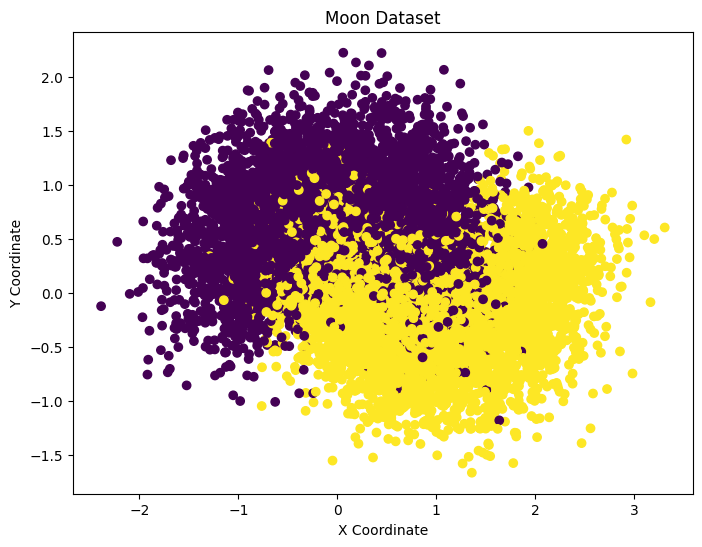

In [49]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    mean_squared_error,
    accuracy_score,
    precision_score,
    recall_score,
    roc_curve,
    auc,
)
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.preprocessing import StandardScaler


X, y = make_moons(n_samples=10000, noise=0.4, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Moon Dataset")
plt.show()

In [50]:
params = {
    "max_leaf_nodes": list(range(2, 20)),
    "min_samples_split": [2, 3, 4],
    "min_samples_leaf": [1, 2, 4],
    "max_depth": list(range(2, 20)),
    "min_impurity_decrease": [0.0, 0.1, 0.2],
    "criterion": ["gini", "entropy"],
}

dt_grid_search_cv = GridSearchCV(
    DecisionTreeClassifier(random_state=42), params, n_jobs=-1, verbose=1, cv=10
)
dt_grid_search_cv.fit(X_train, y_train)
best_dt = dt_grid_search_cv.best_estimator_
best_dt

y_pred_dt = best_dt.predict(X_test)

print("Best parameters:", dt_grid_search_cv.best_params_)

Fitting 10 folds for each of 17496 candidates, totalling 174960 fits
Best parameters: {'criterion': 'gini', 'max_depth': 7, 'max_leaf_nodes': 19, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [56]:
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

params = {
    "C": [10, 20, 30, 40, 50],
    "kernel": ["linear", "rbf", "poly", "sigmoid"],
    "degree": [1, 2, 3],
    "gamma": ["scale", "auto", 1, 0.1, 0.01, 0.001],
}

svc_grid_search_cv = GridSearchCV(
    SVC(random_state=42, cache_size=2048), params, n_jobs=-1, verbose=1, cv=10
)
svc_grid_search_cv.fit(X_train, y_train)
best_svm = svc_grid_search_cv.best_estimator_

y_pred_svm = best_svm.predict(X_test)

print("Best parameters:", svc_grid_search_cv.best_params_)

Fitting 10 folds for each of 360 candidates, totalling 3600 fits


In [52]:
# Calculate the accuracy of the Decision Tree model
accuracy_dt = accuracy_score(y_test, y_pred_dt)

# Calculate the accuracy of the SVM model
accuracy_svm = accuracy_score(y_test, y_pred_svm)

# Print the accuracies
print("Decision Tree Accuracy:", accuracy_dt)
print("SVM Accuracy:", accuracy_svm)

if accuracy_dt > accuracy_svm:
    print("Decision Tree performs better than SVM")
elif accuracy_dt < accuracy_svm:
    print("SVM performs better than Decision Tree")
else:
    print("Decision Tree and SVM have the same accuracy")

Decision Tree Accuracy: 0.87
SVM Accuracy: 0.872
SVM performs better than Decision Tree


In [53]:
# Calculate the accuracy on the training set
y_pred_train_dt = best_dt.predict(X_train)
accuracy_train_dt = accuracy_score(y_train, y_pred_train_dt)

y_pred_train_svm = best_svm.predict(X_train)
accuracy_train_svm = accuracy_score(y_train, y_pred_train_svm)

# Print the accuracies on the training and test sets
print("Decision Tree - Training Accuracy:", accuracy_train_dt)
print("Decision Tree - Test Accuracy:", accuracy_dt)

print("SVM - Training Accuracy:", accuracy_train_svm)
print("SVM - Test Accuracy:", accuracy_svm)

if accuracy_train_dt > accuracy_dt:
    print("Decision Tree may be overfitting. Tune the parameters")

if accuracy_train_svm > accuracy_svm:
    print("SVM may be overfitting. Tune the parameters")

Decision Tree - Training Accuracy: 0.863875
Decision Tree - Test Accuracy: 0.87
SVM - Training Accuracy: 0.865625
SVM - Test Accuracy: 0.872


Best Decision Tree:
MSE: 0.13
Accuracy: 0.87
Precision: 0.8782518210197711
Recall: 0.8551165146909828

Best SVM:
MSE: 0.128
Accuracy: 0.872
Precision: 0.8695652173913043
Recall: 0.8713272543059777


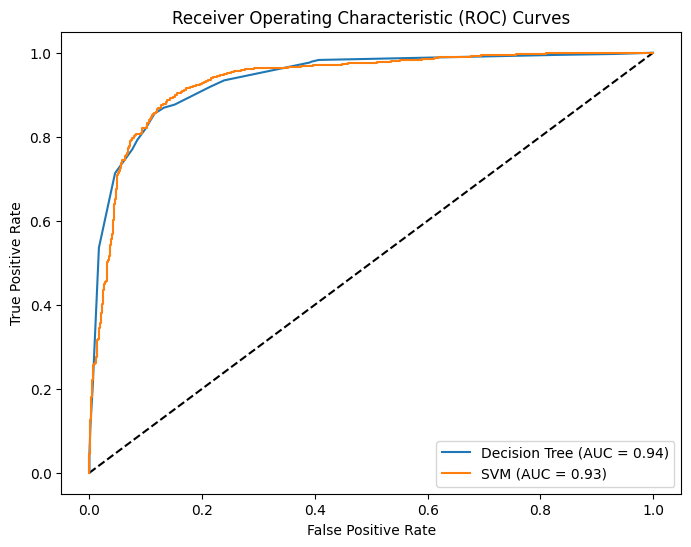

In [54]:
# Calculate metrics for the best Decision Tree model
y_pred_dt = best_dt.predict(X_test)
mse_dt = mean_squared_error(y_test, y_pred_dt)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)

# Calculate metrics for the best SVM model
y_pred_svm = best_svm.predict(X_test)
mse_svm = mean_squared_error(y_test, y_pred_svm)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)

# Print the metrics
print("Best Decision Tree:")
print("MSE:", mse_dt)
print("Accuracy:", accuracy_dt)
print("Precision:", precision_dt)
print("Recall:", recall_dt)

print("\nBest SVM:")
print("MSE:", mse_svm)
print("Accuracy:", accuracy_svm)
print("Precision:", precision_svm)
print("Recall:", recall_svm)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], "k--")  # Plot the diagonal line

# Plot ROC curve for the best Decision Tree model
fpr_dt, tpr_dt, _ = roc_curve(y_test, best_dt.predict_proba(X_test)[:, 1])
plt.plot(
    fpr_dt, tpr_dt, label="Decision Tree (AUC = {:.2f})".format(auc(fpr_dt, tpr_dt))
)

# Plot ROC curve for the best SVM model
fpr_svm, tpr_svm, _ = roc_curve(y_test, best_svm.decision_function(X_test))
plt.plot(fpr_svm, tpr_svm, label="SVM (AUC = {:.2f})".format(auc(fpr_svm, tpr_svm)))

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curves")
plt.legend(loc="lower right")
plt.show()

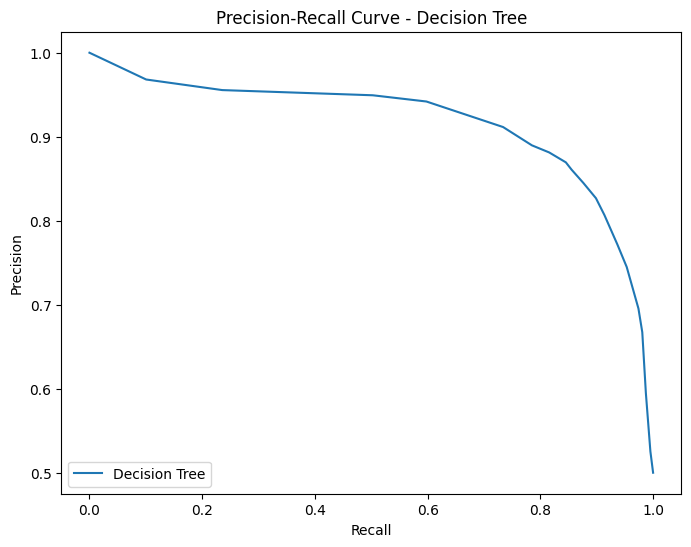

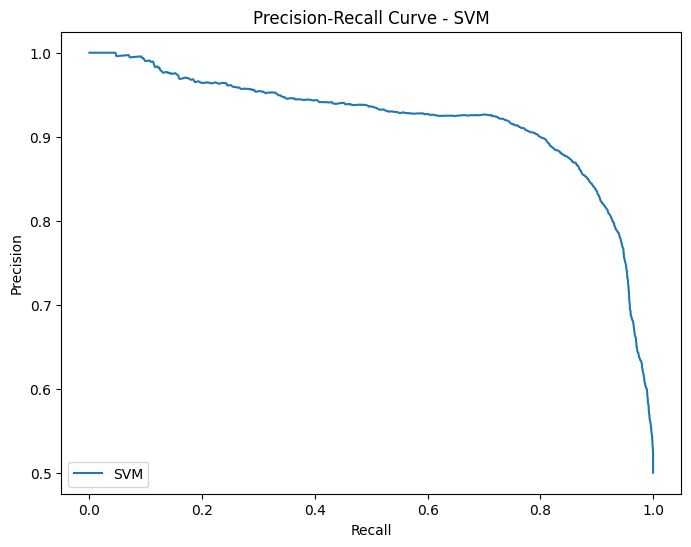

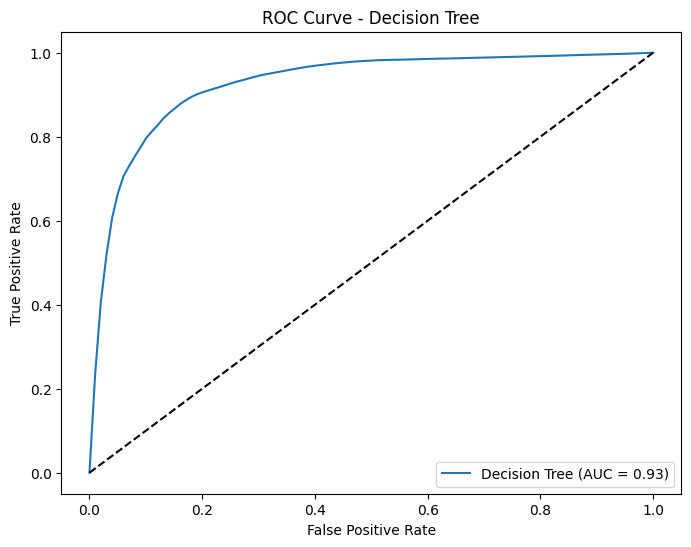

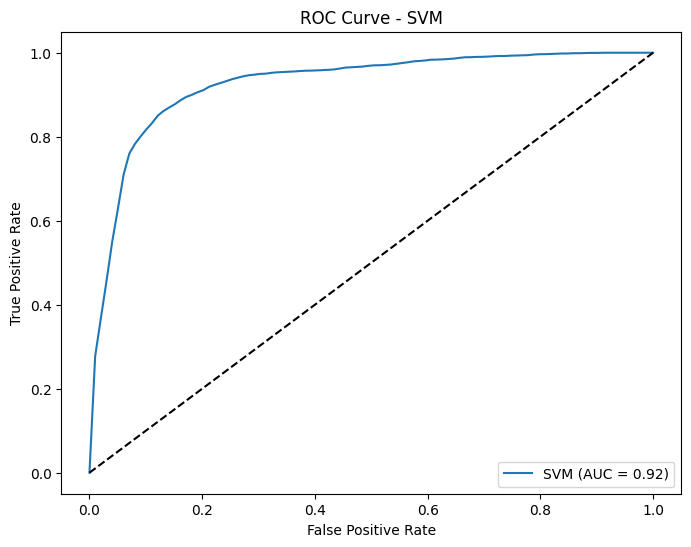

In [55]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Create the StratifiedKFold object
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Plot Precision-Recall curve for Decision Tree
plt.figure(figsize=(8, 6))
precisions_dt = []
recalls_dt = []
for train_index, test_index in cv.split(X, y):
    y_pred_proba_dt = best_dt.fit(X[train_index], y[train_index]).predict_proba(
        X[test_index]
    )[:, 1]
    precision_dt, recall_dt, _ = precision_recall_curve(y[test_index], y_pred_proba_dt)
    precisions_dt.append(precision_dt)
    recalls_dt.append(recall_dt)
plt.plot(
    np.mean(recalls_dt, axis=0), np.mean(precisions_dt, axis=0), label="Decision Tree"
)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Decision Tree")
plt.legend(loc="lower left")
plt.show()

# Plot Precision-Recall curve for SVM
plt.figure(figsize=(8, 6))
precisions_svm = []
recalls_svm = []
for train_index, test_index in cv.split(X, y):
    y_pred_score_svm = best_svm.fit(X[train_index], y[train_index]).decision_function(
        X[test_index]
    )
    precision_svm, recall_svm, _ = precision_recall_curve(
        y[test_index], y_pred_score_svm
    )
    precisions_svm.append(precision_svm)
    recalls_svm.append(recall_svm)
plt.plot(np.mean(recalls_svm, axis=0), np.mean(precisions_svm, axis=0), label="SVM")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - SVM")
plt.legend(loc="lower left")
plt.show()

# Plot ROC curve for Decision Tree
plt.figure(figsize=(8, 6))
fprs_dt = []
tprs_dt = []
aucs_dt = []
mean_fpr_dt = np.linspace(0, 1, 100)
for train_index, test_index in cv.split(X, y):
    y_pred_proba_dt = best_dt.fit(X[train_index], y[train_index]).predict_proba(
        X[test_index]
    )[:, 1]
    fpr_dt, tpr_dt, _ = roc_curve(y[test_index], y_pred_proba_dt)
    interp_tpr_dt = np.interp(mean_fpr_dt, fpr_dt, tpr_dt)
    interp_tpr_dt[0] = 0.0
    tprs_dt.append(interp_tpr_dt)
    aucs_dt.append(auc(fpr_dt, tpr_dt))
mean_tpr_dt = np.mean(tprs_dt, axis=0)
mean_auc_dt = auc(mean_fpr_dt, mean_tpr_dt)
plt.plot(
    mean_fpr_dt, mean_tpr_dt, label="Decision Tree (AUC = {:.2f})".format(mean_auc_dt)
)
plt.plot([0, 1], [0, 1], "k--")  # Plot the diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Decision Tree")
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for SVM
plt.figure(figsize=(8, 6))
fprs_svm = []
tprs_svm = []
aucs_svm = []
mean_fpr_svm = np.linspace(0, 1, 100)
for train_index, test_index in cv.split(X, y):
    y_pred_score_svm = best_svm.fit(X[train_index], y[train_index]).decision_function(
        X[test_index]
    )
    fpr_svm, tpr_svm, _ = roc_curve(y[test_index], y_pred_score_svm)
    interp_tpr_svm = np.interp(mean_fpr_svm, fpr_svm, tpr_svm)
    interp_tpr_svm[0] = 0.0
    tprs_svm.append(interp_tpr_svm)
    aucs_svm.append(auc(fpr_svm, tpr_svm))
mean_tpr_svm = np.mean(tprs_svm, axis=0)
mean_auc_svm = auc(mean_fpr_svm, mean_tpr_svm)
plt.plot(mean_fpr_svm, mean_tpr_svm, label="SVM (AUC = {:.2f})".format(mean_auc_svm))
plt.plot([0, 1], [0, 1], "k--")  # Plot the diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - SVM")
plt.legend(loc="lower right")
plt.show()